# Dependencies

In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install opencv-contrib-python

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2 as cv
import os
import PIL
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Loss Function
#### Batches
#### Optimizer
- Adam
- SGD
#### Validation Set
#### Data Augmentaion

# Dataset

In [4]:
testing_images_path  = './images/testing'

### Load the train images from folders

In [5]:
img_height, img_width, img_channels = 180, 180, 3
batch_size=32
data_dir = '.\images\\training'
test_data_dir = '.\images\\testing'
loading_dataste_seed = 0

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 597 files belonging to 2 classes.


In [22]:
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation between -10 to +10 degrees
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False,  # No vertical flip
    fill_mode='nearest'  # Fill mode for filling any newly created pixels
)

# Convert the TensorFlow dataset to numpy arrays
x_train = []
y_train = []
for images, labels in train_ds:
    x_train.append(images.numpy())
    y_train.append(labels.numpy())
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

# Apply data augmentation using the ImageDataGenerator
augmented_images = []
augmented_labels = []
for batch in datagen.flow(x_train, y_train, batch_size=1):
    augmented_images.append(batch[0])
    augmented_labels.append(batch[1])
    if len(augmented_images) == len(x_train) * 2:
        break

# Convert the augmented images and labels back to TensorFlow dataset
augmented_train_ds = tf.data.Dataset.from_tensor_slices((np.concatenate(augmented_images), np.concatenate(augmented_labels)))
augmented_train_ds = augmented_train_ds.batch(batch_size)

# print(train_ds)
# augmented_train_ds = datagen.flow(train_ds, batch_size=1)



# final_train_ds = train_ds.concatenate(augmented_train_ds).shuffle(1000).batch(batch_size)

In [23]:
np.concatenate(augmented_images).shape

(1914, 180, 180, 3)

In [18]:
train_ds

In [14]:
x_train.shape

In [19]:
count = 0
for images, labels in augmented_train_ds:
    count += len(images)
print(count)

In [24]:
classes_names = train_ds.class_names
print(classes_names)

['flip', 'notflip']


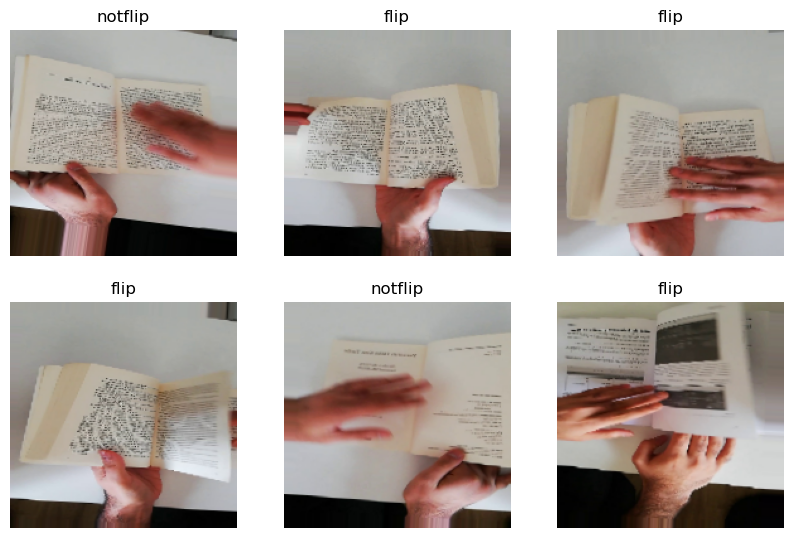

In [34]:
plt.figure(figsize=(10, 10))  # Create a new figure with a size of 10x10 inches

# Iterate over the first batch of images and labels from the train dataset
for images, labels in augmented_train_ds.take(1):
    # Iterate over each image in the batch
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot within a 3x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.title(classes_names[labels[i]])  # Set the title as per the corresponding label
        plt.axis("off")  # Turn off the axis labels and ticks

plt.show()  # Display the plot


In [35]:
def get_random_test_image(label):
    testing_images_flip = os.listdir(testing_images_path + '/flip')
    testing_images_notflip = os.listdir(testing_images_path + '/notflip')
    
    random_image_path = random.choice(testing_images_flip if label == 'flip' else testing_images_notflip)
    test_image_path = testing_images_path + '/' + label +'/' + random_image_path

    test_image = cv.imread(test_image_path)
    test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB) # Convert the image from BGR to RGB
    test_image_resized = cv.resize(test_image, (img_height, img_width))
    test_image = np.expand_dims(test_image_resized, axis=0) # This line expands the dimensions of test_image_resized along the first axis using np.expand_dims() from NumPy. It adds an extra dimension to make the image compatible with models that expect a batch of images

    # Display the image using matplotlib
    plt.imshow(test_image_resized)
    plt.axis('off')  # Turn off the axis labels
    plt.show()

    return test_image

In [36]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, data):
    predictions = model.predict(data)
    true_labels = []
    predicted_labels = []

    for images, labels in test_ds:
        true_labels.extend(labels.numpy())
        predicted_labels.extend(tf.argmax(model.predict(images), axis=1).numpy())

    cm = confusion_matrix(true_labels, predicted_labels)
    
    class_names = test_ds.class_names
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Train Model

## 1. Custom

In [37]:
custom_model = models.Sequential([
    # CNN Layers 01
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(img_width, img_height, img_channels)
    ),
    layers.MaxPooling2D((2, 2)),
    
    # CNN Layers 02
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu'
    ),
    layers.MaxPooling2D((2, 2)),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(classes_names), activation='softmax'),
])

custom_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59168)             0         
                                                                 
 dense (Dense)               (None, 64)                3

In [39]:
custom_model_history = custom_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
60/60 [==============================] - 72s 1s/step - loss: 57.4533 - accuracy: 0.7048 - val_loss: 0.2666 - val_accuracy: 0.8724
Epoch 2/10
60/60 [==============================] - 72s 1s/step - loss: 0.1386 - accuracy: 0.9420 - val_loss: 0.1236 - val_accuracy: 0.9456
Epoch 3/10
60/60 [==============================] - 60s 981ms/step - loss: 0.0297 - accuracy: 0.9922 - val_loss: 0.0512 - val_accuracy: 0.9791
Epoch 4/10
60/60 [==============================] - 61s 987ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.0918 - val_accuracy: 0.9665
Epoch 5/10
60/60 [==============================] - 75s 1s/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0386 - val_accuracy: 0.9833
Epoch 6/10
60/60 [==============================] - 102s 2s/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0474 - val_accuracy: 0.9833
Epoch 7/10
60/60 [==============================] - 116s 2s/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0204 - val_accuracy: 0.9937
Epoch 8/10


### Evaluating The Model

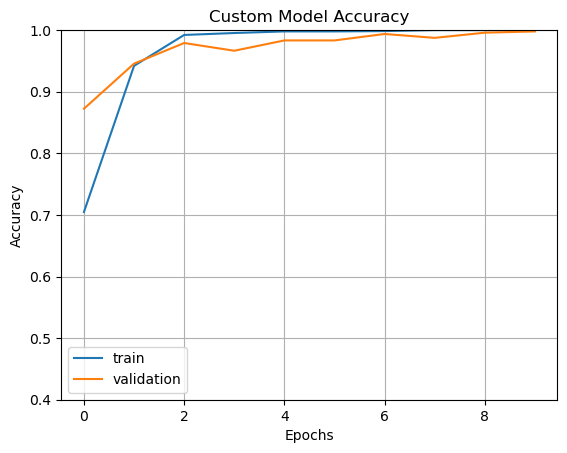

In [40]:
fig1 = plt.gcf()
plt.plot(custom_model_history.history['accuracy'])
plt.plot(custom_model_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Custom Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

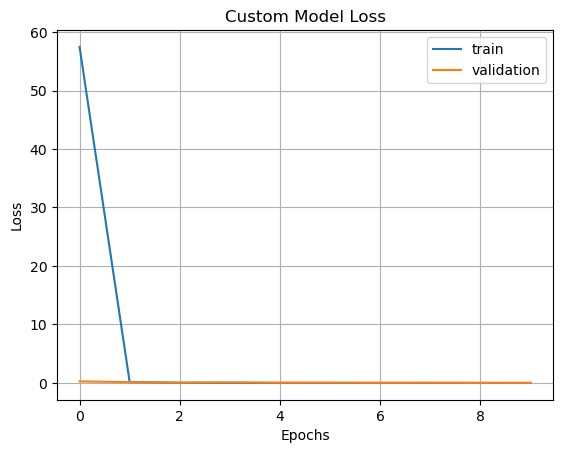

In [41]:
plt.plot(custom_model_history.history['loss'])
plt.plot(custom_model_history.history['val_loss'])
plt.grid()
plt.title('Custom Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 0s 375ms/step


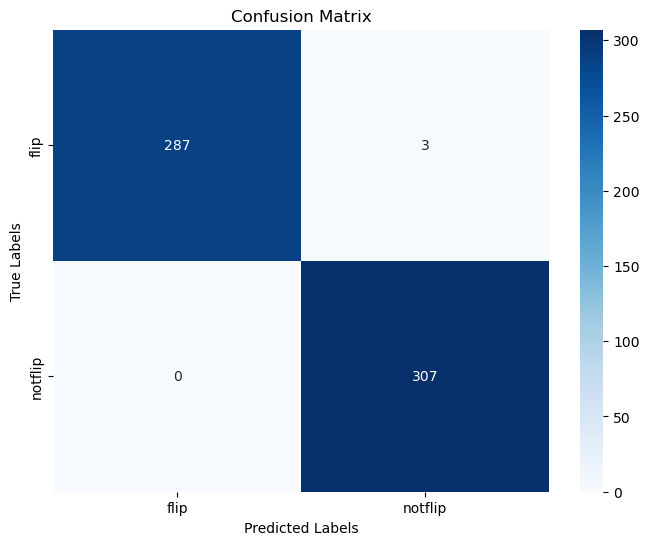

In [42]:
get_confusion_matrix(custom_model, test_ds)

## 2. ResNet

In [55]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_width, img_height, img_channels),
    pooling='avg',
    classes=len(classes_names),
    weights='imagenet'
)

for layer in pretrained_model.layers:
        # layer.trainable = False
        layer.trainable = True

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

resnet_model.add(Dense(len(classes_names), activation='softmax'))

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_6 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 64)               131136    
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 2)                130       
 pper)                                                           
                                                                 
Total params: 23,718,978
Trainable params: 23,665,858
Non-trainable params: 53,120
_____________________________________

In [57]:
resnet_model_history = custom_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
60/60 [==============================] - 127s 2s/step - loss: 9.1890e-06 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9979
Epoch 2/5
60/60 [==============================] - 143s 2s/step - loss: 8.5465e-06 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9979
Epoch 3/5
60/60 [==============================] - 154s 2s/step - loss: 7.9686e-06 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9979
Epoch 4/5
60/60 [==============================] - 151s 2s/step - loss: 7.4558e-06 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9979
Epoch 5/5
60/60 [==============================] - 150s 2s/step - loss: 7.0415e-06 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 0.9979


### Evaluating The Model

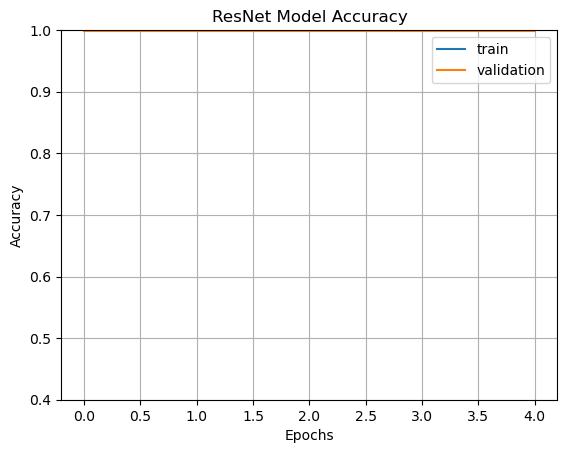

In [58]:
fig1 = plt.gcf()
plt.plot(resnet_model_history.history['accuracy'])
plt.plot(resnet_model_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

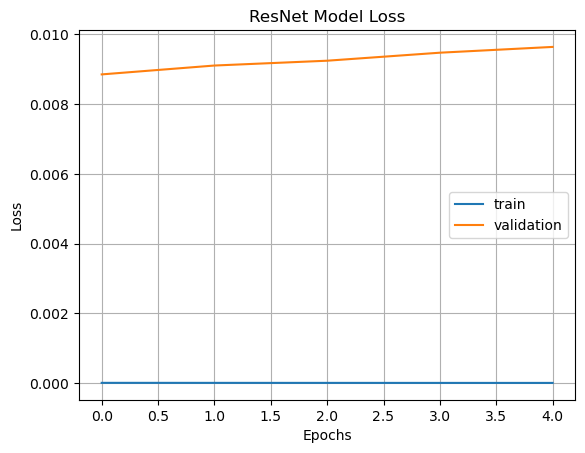

In [59]:
plt.plot(resnet_model_history.history['loss'])
plt.plot(resnet_model_history.history['val_loss'])
plt.grid()
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 5s 5s/step


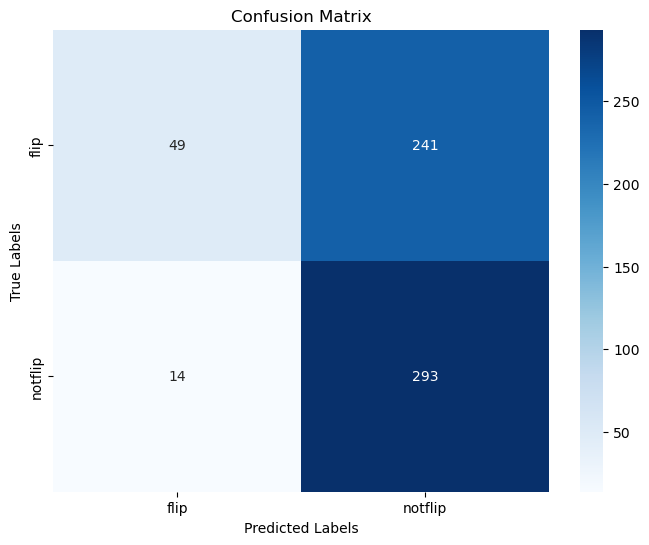

In [60]:
get_confusion_matrix(resnet_model, test_ds)

## 2. MobileNet

In [49]:
mobilenet_model = Sequential()

mobilenet_pretrained_model= tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=(img_width, img_height, img_channels),
    pooling='avg',
    classes=len(classes_names),
    weights='imagenet'
)

for layer in mobilenet_pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(mobilenet_pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(len(classes_names), activation='softmax'))

In [50]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 module_wrapper_3 (ModuleWra  (None, 1280)             0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              655872    
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 2)                1026      
 pper)                                                           
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-

In [51]:
mobilenet_model_history = custom_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/10
60/60 [==============================] - 146s 2s/step - loss: 2.1555e-05 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9979
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 1.9510e-05 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 0.9979
Epoch 3/10
60/60 [==============================] - 106s 2s/step - loss: 1.7661e-05 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9979
Epoch 4/10
60/60 [==============================] - 104s 2s/step - loss: 1.6236e-05 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9979
Epoch 5/10
60/60 [==============================] - 103s 2s/step - loss: 1.4584e-05 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9979
Epoch 6/10
60/60 [==============================] - 101s 2s/step - loss: 1.3351e-05 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9979
Epoch 7/10
60/60 [==============================] - 101s 2s/step - loss: 1.2433e-05 - accuracy: 1.0000 - val_loss: 0.0082 - val_ac

### Evaluating The Model

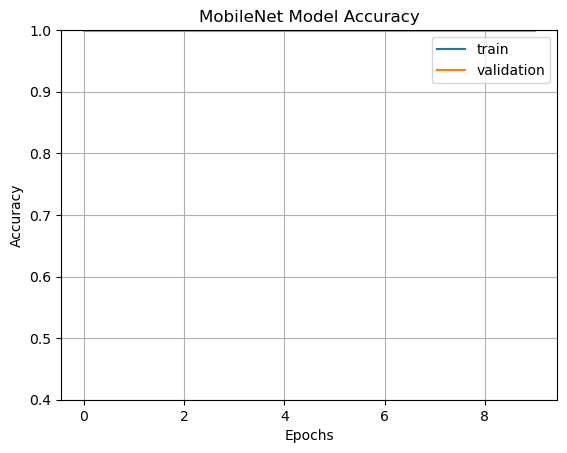

In [53]:
fig1 = plt.gcf()
plt.plot(mobilenet_model_history.history['accuracy'])
plt.plot(mobilenet_model_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('MobileNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

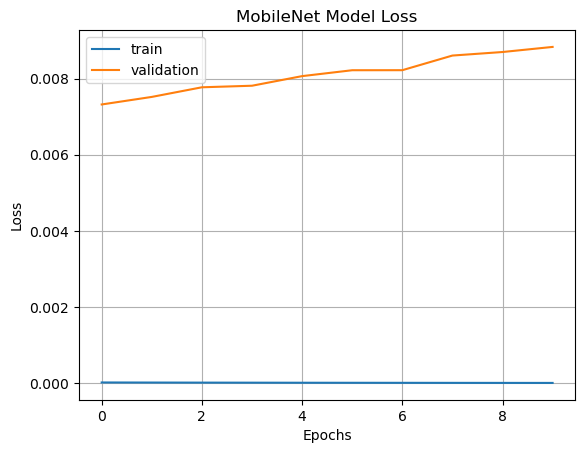

In [54]:
plt.plot(mobilenet_model_history.history['loss'])
plt.plot(mobilenet_model_history.history['val_loss'])
plt.grid()
plt.title('MobileNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 3s 3s/step


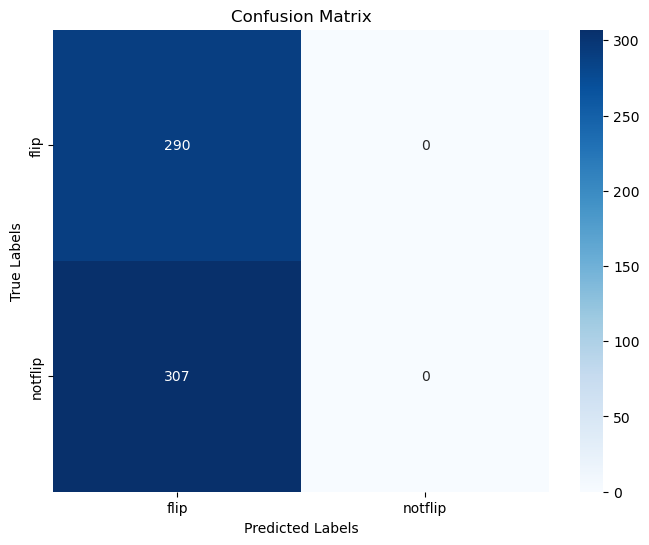

In [52]:
get_confusion_matrix(mobilenet_model, test_ds)